<b><h1>IoTwins.bayesian_optimization service</h1></b>
The bayesian_optimization service developed in IoTwins is meant to support and allow clients to make hyperparameter fine-tuning.<br>This service can be used to automatically improve the performances of the already existing services as well as future services that will be developed and added in the IoTwins context. <br>
Why was this service developed? The IoTwins services are applicable in across a wide range of contexts and specifically in the area of anomaly detection.<br>
To work best, these services need specific and not always easy to find configurations that usually involve experts' work. The bayesian_optimization aims to remove this gap and allow any clients to automatically individuate the best hyperparameters configuration in an acceptable time.


The bayesian_optimization service is a wrapper of the <a href="https://github.com/hyperopt/hyperopt">Hyperopt</a> python library for serial and parallel optimization over awkward search spaces, which may include real-valued, discrete, and confitional dimensions.<br>
To conclude, the purpose of the service is to facilitate the use of the IoTwins services and make hyperparameter fine-tuning in the context of the client in the easiest and fastest manner. 

<b><h2>Optimization Example in IoTwins[bayesian_optimization service]</h2></b>
Formulating an optimization problem requires four main parts:<br>
    - <b>Objective Function</b>[mandatory]: takes in an input and returns a loss to minimize.<br>
    - <b>Domain space</b>[mandatory]: the range of input values to evaluate.<br>
    - <b>Optimization Algorithm</b>[default <a href="https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf">tpe</a>]: the method used to construct the surrogate function and choose the next values to evaluate. <b>use the default value!</b><br>
    - <b>Results</b>[not mandatory]: score, value pairs that the algorithm uses to build the model. <b>Managed by the service</b>.<br>

In [1]:
# pandas and numpy
import pandas as pd
import numpy as np

# matplotlib for graphs
import matplotlib.pyplot as plt

<b>Objective Function - the <a href="https://github.com/hyperopt/hyperopt">Rosenbrock</a> function</b><br>
In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms. The global minimum is inside a long, narrow, parabolic shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult.<br>
Usually the two function's parameters are set such that <b>a=1</b> and <b>b=100</b> in order to have the global minimum at <b>x=1, y=1</b>(f(x,y)=0)<br>
The <u>objective function</u> can be any function that returns a real value that we want to minimize, so we can try to optimize the Rosenbrock function.<br>

In addition, we usually also need the <u>saving model function</u> (not for this basic example) in order to save locally whatever we want during the optimization process.

In [2]:
a = 1
b = 100
def rosenbrock(x, y):  # I want to search the best 'x'
    """Rosenbrock Objective function to minimize"""
    # Create the polynomial object
    return ((a - x)**2 + b*(y - x**2)**2), {}, {}

save_model_f = None  # save_model_func parameter for the bayesian optimization service

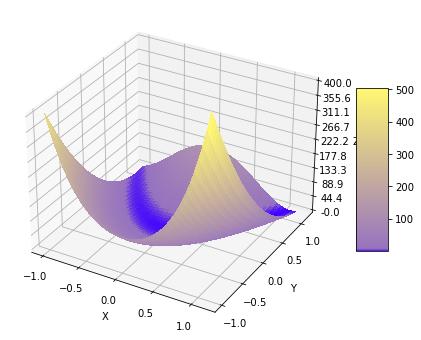

In [3]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as m
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}

cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

fig = plt.figure(figsize = (8, 6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1.2, 0.05)
Y = np.arange(-1, 1.2, 0.05)
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
R, _, _ = rosenbrock(np.ravel(X),np.ravel(Y))
zs = np.array(R)
Z = zs.reshape(X.shape)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.01, 400)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.01f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

<b>Domain Space</b><br>
The domain space is the input values over which we want to search.<br>
This part may be the most difficult part to handle, however the bayesian_optimization service<br>
require the same space domain format as for the Hyperopt(<a href="http://hyperopt.github.io/hyperopt/getting-started/search_spaces/">How to define a Search Space</a>).<br>
<br>
Sometimes may be needed to pass fixed paramters to the objective function, parameters which are not part of the search space.<br>
This can be done passing a dict to the <i>"others_params"</i> bayesian_optimiztion's parameter.<br>
<br>
In our example we have only two parameters, the <i>x</i> and <i>y</i> values which can follow any kind of distribution.

let's use the uniform distribution for <i>x</i> and <i>y</i>.

In [4]:
from hyperopt import hp
# Domain Space
s = {'x': hp.uniform('x', -3, 3), 'y': hp.uniform('y', -3, 3)}

# Fixed Parameters
o_p = {}  # no fixed parameters

<b>Optimization Algorithm</b> - Not Mandatory, managed by the service.<br>
As default the Tree-structured Parzen Estimator model is used inside the service, <br>
but it is possible to change it passing an algorithm to the <i>"opt_algorithm"</i> parameter.<br>
The service, and Hyperopt, support as default the: Random Search, Tree of Parzen Estimators (TPE) and Adaptive TPE. See the <a href="Tree of Parzen Estimators (TPE)">Supported Algorithms</a>

In [5]:
# Not mandatory, as default the service uses the tpe as well
from hyperopt import tpe
# Create the algorithm
tpe_algo = tpe.suggest

<b>Results (Trials)</b> - not Mandatory, managed by the service<br>
This is not strictly necessary as Hyperopt keeps track of the results for the algorithm internally.<br>
However, since we want to inspect the progression of the alogorithm, the service creates a Trials object that will record the values and the scores.<br>

<b><h3>Optimization</h3></b><br>
Now that the problem is defined, we can minimize our objective function!<br>
To do so, we use the <i>bayesian_optimization</i> service that takes the four parts above, as well as a maximum number of evaluations:

In [6]:
from servises.bayesian_optimization.src.bayesianOptimization import bayesian_optimization, _load_trials
out_file = "rosenbrock_trials.csv"
t_e = 5000  # total_evals
best, trial_fname = bayesian_optimization(function_to_optimize=rosenbrock, trial_fname=out_file, space=s, total_evals=t_e, 
                                          save_model_func=None)

print("\n\ntrial_fname: {}".format(trial_fname))

print("BEST parameter/s:")
print(best)

Using TensorFlow backend.


100%|██████████| 5000/5000 [03:13<00:00, 25.89trial/s, best loss: 0.00016153239687609767]
[BO] trial saved


trial_fname: C:\Users\Filippo\Documents\Python\IoTwins_Bayesian_Optimization\servises\bayesian_optimization/out/trials_5000_default_0.0.p
BEST parameter/s:
{'x': 0.991911716368977, 'y': 0.9848692206785531}


In [7]:
import os
trial_filename, _ = os.path.splitext(trial_fname)
print(trial_filename)

tpe_trials = _load_trials(trial_filename)

# Dataframe of results from optimization
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x'],
                            'y': tpe_trials.idxs_vals[1]['y']})

tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.loc[tpe_results['loss'] <= 0.1]

C:\Users\Filippo\Documents\Python\IoTwins_Bayesian_Optimization\servises\bayesian_optimization/out/trials_5000_default_0.0
[BO] trial loaded


,loss,iteration,x,y,rolling_average_x,rolling_average_loss
147,0.073696,147,1.195817,1.411176,0.256336,811.672943
166,0.032225,166,0.825303,0.676994,0.372319,642.422823
217,0.054344,217,0.777857,0.612130,0.937336,665.513771
315,0.074939,315,0.844194,0.735171,1.036178,302.682365
490,0.056212,490,0.979030,0.982117,0.596258,420.992983
...,...,...,...,...,...,...
4914,0.031112,4914,0.853129,0.737597,1.031160,82.880704
4947,0.093930,4947,0.874291,0.736433,0.831487,61.084998
4965,0.098553,4965,0.917417,0.871941,0.844456,72.337812
4978,0.001074,4978,0.967768,0.935980,0.843125,69.967183


Over time, the input values cluster around the optimal indicated by the red line. This is a simple problem, so the algorithm does not have much trouble finding the best value of x.

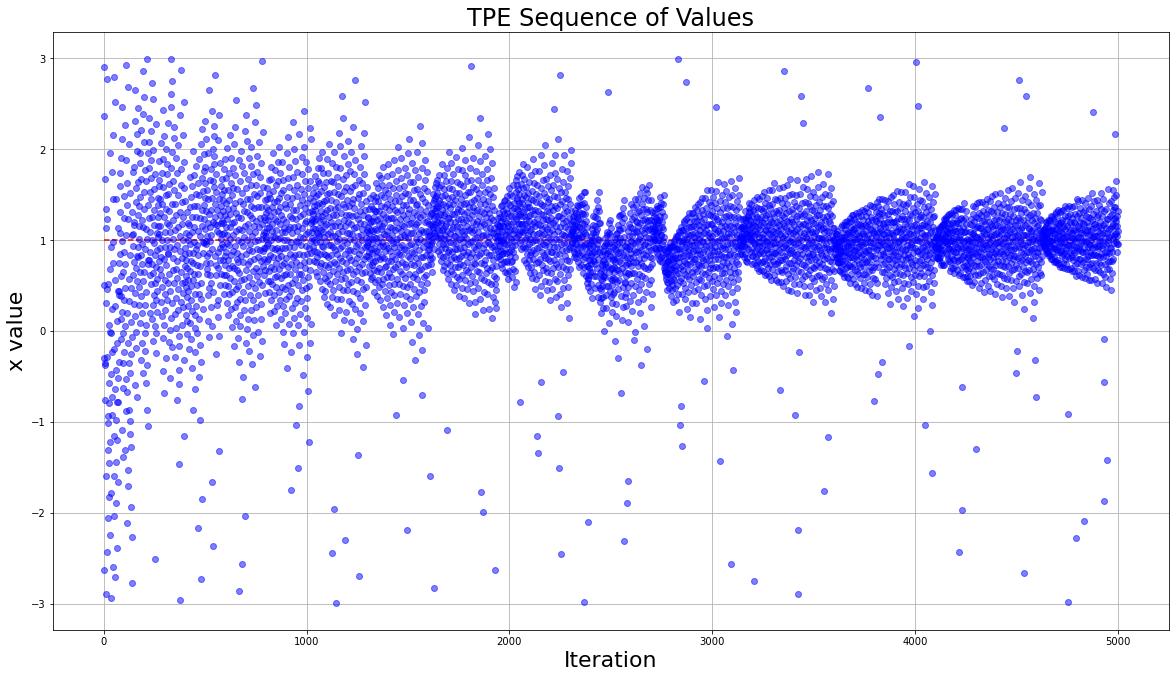

In [10]:
plt.figure(figsize = (20, 11))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(1, 0, 5000, linestyles = '--', colors = 'r');
plt.grid();

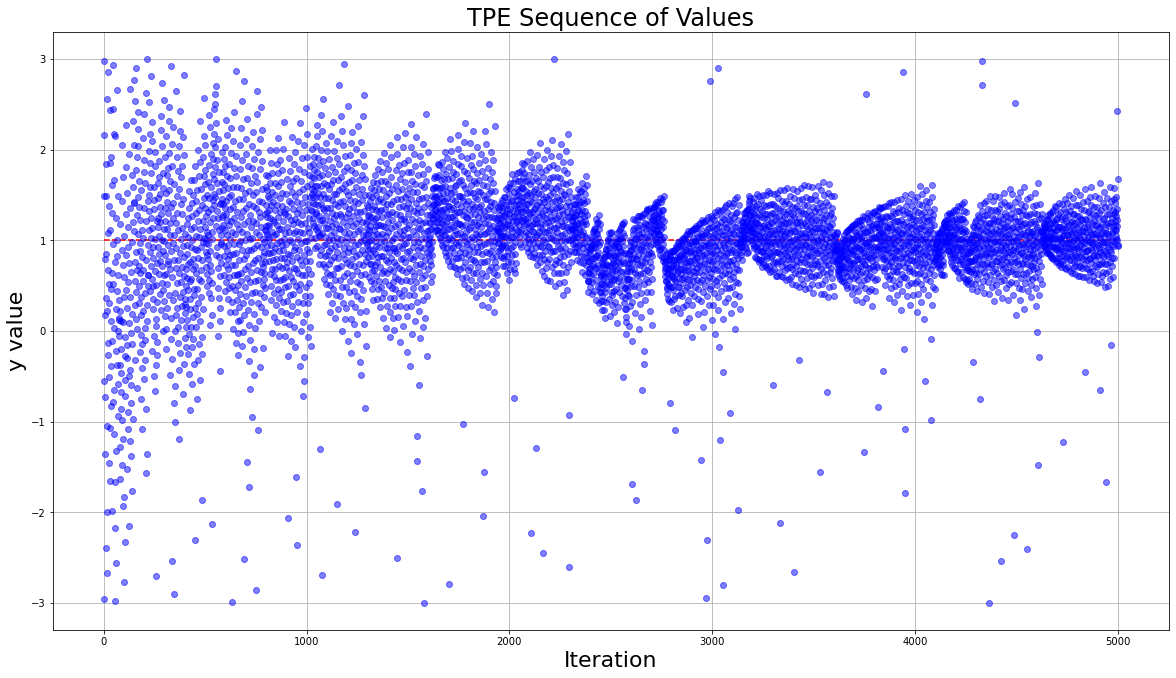

In [11]:
plt.figure(figsize = (20, 11))
plt.plot(tpe_results['iteration'], tpe_results['y'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('y value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(1, 0, 5000, linestyles = '--', colors = 'r');
plt.grid();

We can also plot the histograms to see the distribution of the tested values.

<Figure size 576x2160 with 0 Axes>

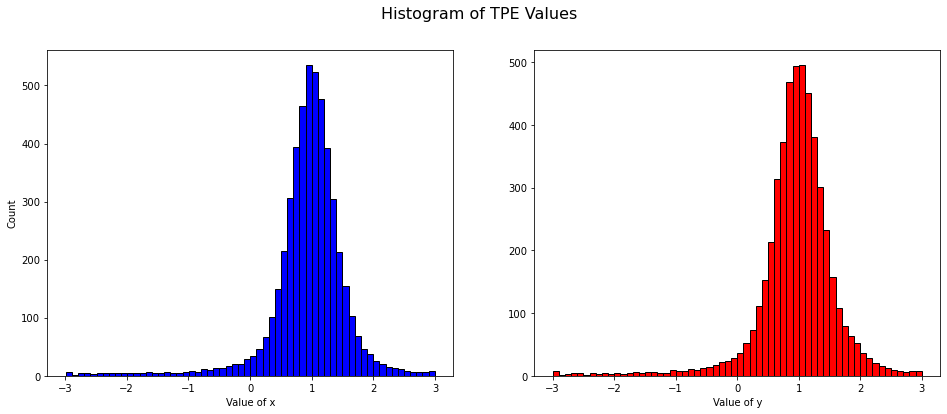

In [33]:
plt.figure(figsize = (8, 30))
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16);
fig.set_figheight(6);
fig.suptitle('Histogram of TPE Values', fontsize=16)

#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#axes[0].hist(list1, bins, alpha = 0.5, color = 'r')
axes[0].hist(tpe_results['x'], bins = 60, edgecolor = 'k', color = 'b');
axes[1].hist(tpe_results['y'], bins = 60, edgecolor = 'k', color = 'r');
axes[0].set_xlabel('Value of x'); axes[0].set_ylabel('Count');
axes[1].set_xlabel('Value of y');

Best Loss of 0.0002 occured at iteration 3138


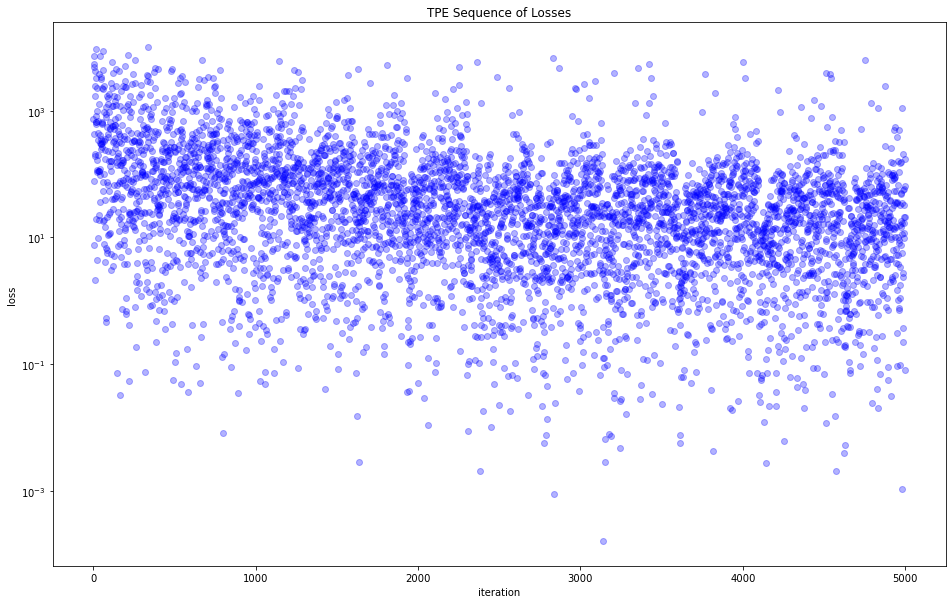

In [44]:
# Sort with best loss first
tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()
plt.figure(figsize = (16, 10))
plt.yscale("log")
plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');

print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

Here we see the main benefit of Bayesian model-based optimization: more concentration on promising input values. When we are searching over dozens of parameters and each eval takes hours or days, reducing the number of evals is critical. Bayesian optimization minimizes the number of evals by reasoning based on previous results what input values should be tried in the future.

<b><h2>Conclusions</h2></b>

Bayesian model-based optimization is intuitive: choose the next input values to evaluate based on the past results to concentrate the search on more promising values. The end outcome is a reduction in the total number of search iterations compared to uninformed random or grid search methods.

<b><h2>What's next?</h2></b>

Follow the next example to learn how to use the bayesian_optimization service with a generic machine learning model(a classifier).